<a href="https://colab.research.google.com/github/dpriyabijosh/Depression_detection/blob/main/ELMo_model_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import keras
import os
import re
import nltk
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
import gensim 
from gensim.models import Word2Vec 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import trange, tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [2]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import os

# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/Colab Notebooks/Models_v2"
os.chdir(path)

Mounted at /content/drive


importing Jupyter notebook from DepressionDetection_preprocessing.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.1/110.1 KB 7.1 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raw_tweet  10314 non-null  object
 1   label      10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


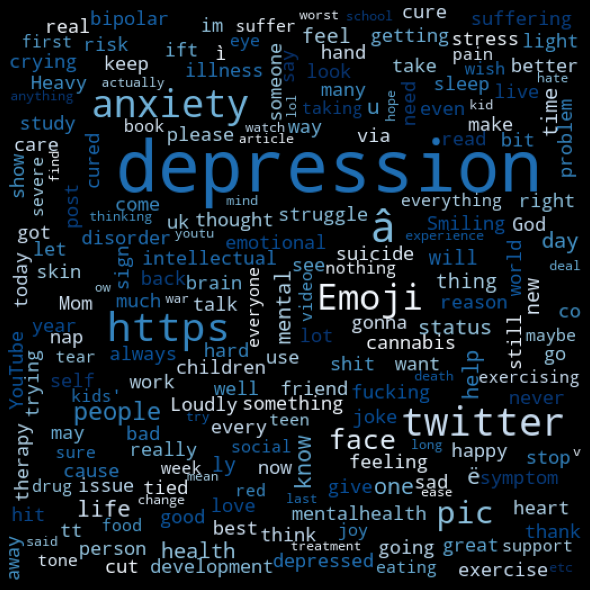

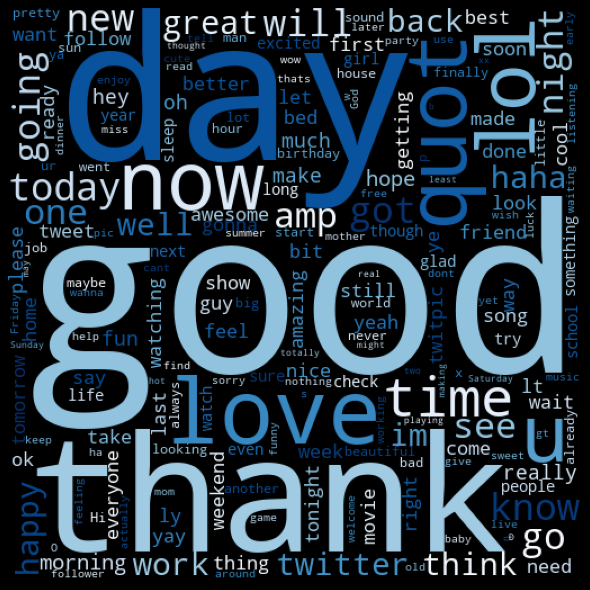

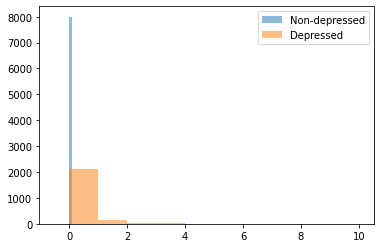

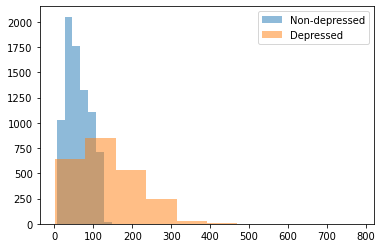

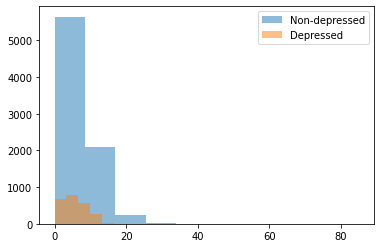

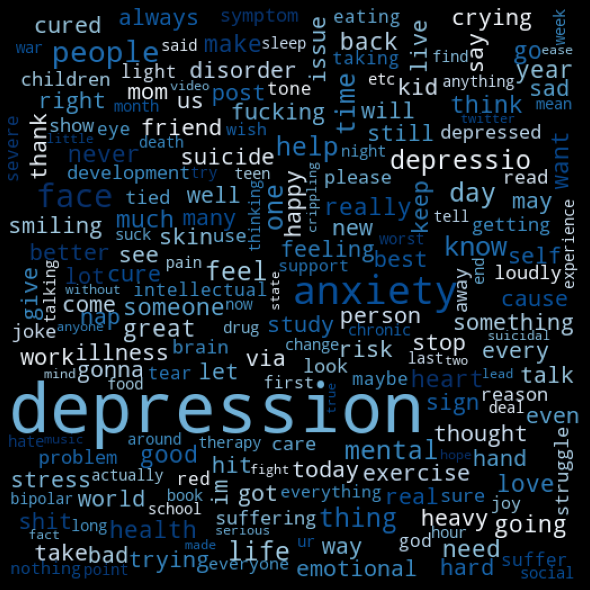

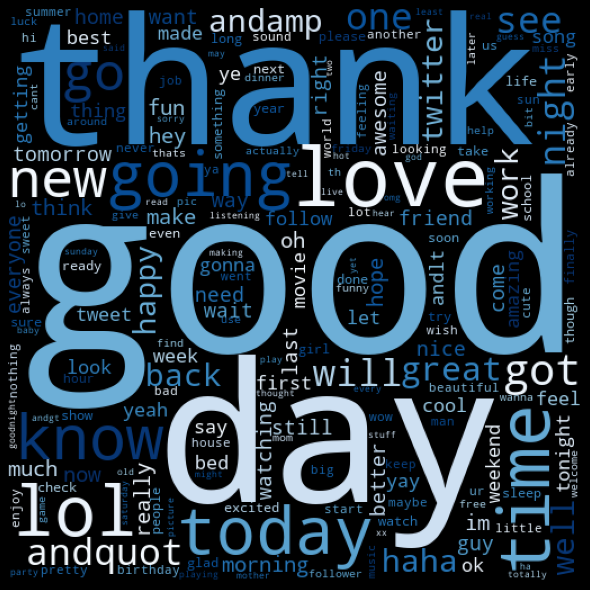

Total number of empty tweets
 label    7
tweet     
dtype: object
(10314, 2)
Initial size (10314, 2)
Shape after cleaning (10280, 2)
Initial size (10280, 2)
Shape after cleaning (10260, 2)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial size (10314, 2)
Shape after cleaning (10278, 2)


In [4]:
import import_ipynb
from DepressionDetection_preprocessing import *

In [5]:
#Load dataset
data = initail_dataload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load data and set labels

#Rename the columns
data.rename(columns={'raw_tweet' :'tweet'},inplace=True)

In [7]:
import torch

In [8]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [9]:
data.sample(5)

,tweet,label
4033,@pworld12 YES.. THANK GOD.. MUCH APRECiATED BABY,0
10170,Stick with Autism Help Acting On Depression,1
5522,Neighbor in the bldg just brought chz cake bcu...,0
8058,Is there such a thing as seasonal depression b...,1
9164,Will be holding a 24-hour charity stream dedic...,1


In [10]:
! pip install tweet-preprocessor
import preprocessor as p
from tqdm.notebook import tqdm
tqdm.pandas()

# function to clean @, #, and links from tweets
def clean_text(text):
 text = text.replace("#","")

 # Replace '&amp;' with '&'
 text = re.sub(r'&amp;', '&', text)

 # Remove trailing whitespace
 text = re.sub(r'\s+', ' ', text).strip()
 return p.clean(text)

data['tweet'] = data['tweet'].astype(str).progress_map(clean_text)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/10314 [00:00<?, ?it/s]

In [11]:
data.sample(5)

,tweet,label
7128,"actually, it was eight million Stephenie Meyer...",0
342,yeah i wouldnt care if i was in a Disney chann...,0
3300,Just finished a makeshift photoshoot. Dog was ...,0
5879,love you soon?!?,0
1691,Nice vid!!! (More proof of insanity! lmao) The...,0


In [12]:
# import re
# data['tweet'] = data.tweet.apply(basic_clean)

##Load Test data

## 2.2 Test dataset Preparation

In [13]:
# Load data and set labels
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/validation_data.csv', 
                        dtype= {'raw_tweet': str, 'label':int}, nrows=500,  usecols=[0,1])


In [14]:
test_data.head()

,raw_tweet,label
0,@_TASOfficial_ I really miss XYZ since 2016 i ...,1
1,There's not much an 8 mile depression run can'...,1
2,How to Overcome Depression#WednesdayThoughts #...,0
3,Real Talk #Kanye has never pulled himself full...,0
4,@andrea_r so it would seem. Good if you wanted...,0


In [15]:
#Rename the columns
test_data.rename(columns={'raw_tweet' :'tweet'},inplace=True)
# Perform Cleaning and Lemmatization
test_data['tweet'] = test_data['tweet'].apply(clean_tweet)

In [16]:
 # Removing empty rows
test_data = clean_empty_rows(test_data,'tweet')

Initial size (500, 2)
Shape after cleaning (500, 2)


In [17]:
test_data.head()

,tweet,label
0,tasofficial really miss xyz since post anime d...,1
1,there be not much mile depression run cannot f...,1
2,how overcome depression aprile,0
3,real talk never pull fully depression suffer m...,0
4,would seem good want multi user video site als...,0


##Splitting the Data

In [18]:
X_data, y_data = np.array(data['tweet']), np.array(data['label'])
label = data.label.values

X_train = X_data
y_train = y_data
X_test, y_test = np.array(test_data['tweet']), np.array(test_data['label']) 
print('Data Split done.')

Data Split done.


In [19]:
import tensorflow as tf
import tensorflow_hub as hub

In [20]:
elmo = hub.load("https://tfhub.dev/google/elmo/3")


In [21]:
# -*- -*-
"""Custom layer for ELMO for keras
"""
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
import tensorflow_hub as hub


class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(
            K.squeeze(K.cast(x, tf.string), axis=1),
            as_dict=True,
            signature='default',
            )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [22]:
embed = hub.load("https://tfhub.dev/google/elmo/2")

In [23]:
from sklearn import preprocessing
import keras
y = list(data['tweet'])
x = list(data['label'])

In [24]:
x_enc = x
y_enc = y

In [25]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

In [26]:
!pip install --upgrade simple_elmo
from simple_elmo import ElmoModel

model = ElmoModel()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 KB 5.4 MB/s eta 0:00:00


In [29]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  False
Hub version:  0.12.0
GPU is available


In [30]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from tensorflow.keras.layers import (
    Dense,
    Dropout
)
from keras.layers import Lambda
import numpy as np

In [32]:
elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=True)

In [33]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default" ,as_dict = True)["default"]

In [34]:
input_text = Input(shape=(1,) ,dtype=tf.string)
embedding = Lambda(ELMoEmbedding)(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(2, activation='softmax')(dense)
model = Model(inputs =[input_text],outputs =pred)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 lambda (Lambda)             (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 262,914
Trainable params: 262,914
Non-trainable params: 0
_________________________________________________________________


In [35]:
from sklearn.model_selection import train_test_split #Importing to split our data for training
X_train, X_valid, y_train, y_valid = train_test_split(data['tweet'],data['label'],train_size=0.90)

In [36]:
%%time
with tf.compat.v1.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())
    session.run(tf.compat.v1.tables_initializer())
    model.fit(X_train, 
          y_train,
          validation_data=(X_valid, y_valid),
          epochs=4,
          batch_size=32)
    path = '/content/drive/MyDrive/Colab Notebooks/Models_v2/Save_models/ELMo/elmo_model.h5'
    model.save_weights(path)

Train on 9282 samples, validate on 1032 samples
Epoch 1/4
9282/9282 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9581

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9282/9282 [==============================] - 86s 9ms/sample - loss: 0.1415 - accuracy: 0.9581 - val_loss: 0.0950 - val_accuracy: 0.9719
Epoch 2/4
9282/9282 [==============================] - 62s 7ms/sample - loss: 0.0617 - accuracy: 0.9791 - val_loss: 0.0734 - val_accuracy: 0.9777
Epoch 3/4
9282/9282 [==============================] - 69s 7ms/sample - loss: 0.0564 - accuracy: 0.9855 - val_loss: 0.0651 - val_accuracy: 0.9855
Epoch 4/4
9282/9282 [==============================] - 63s 7ms/sample - loss: 0.0421 - accuracy: 0.9877 - val_loss: 0.0520 - val_accuracy: 0.9845
CPU times: user 4min 50s, sys: 25.3 s, total: 5min 15s
Wall time: 4min 42s


In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 lambda (Lambda)             (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 262,914
Trainable params: 262,914
Non-trainable params: 0
_________________________________________________________________


In [38]:
path = '/content/drive/MyDrive/Colab Notebooks/Models_v2/Save_models/ELMo/elmo_model.h5'

In [39]:
with tf.compat.v1.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())
    session.run(tf.compat.v1.tables_initializer())
    model.load_weights(path)
    predicts = model.predict(X_test,batch_size=32)

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [40]:
predicts

array([[3.29089235e-03, 9.96709108e-01],
       [1.41833270e-05, 9.99985814e-01],
       [4.16963104e-08, 1.00000000e+00],
       [2.69530519e-05, 9.99973059e-01],
       [9.96052980e-01, 3.94695112e-03],
       [6.98554888e-02, 9.30144548e-01],
       [3.74266565e-01, 6.25733495e-01],
       [6.40878106e-09, 1.00000000e+00],
       [9.99689102e-01, 3.10919510e-04],
       [9.99133527e-01, 8.66460497e-04],
       [9.99932885e-01, 6.70789959e-05],
       [9.88071442e-01, 1.19285136e-02],
       [2.58492310e-05, 9.99974132e-01],
       [9.99706328e-01, 2.93671153e-04],
       [5.88935393e-07, 9.99999404e-01],
       [9.99968290e-01, 3.17221638e-05],
       [1.62416138e-04, 9.99837518e-01],
       [9.99994993e-01, 4.96067105e-06],
       [2.10552171e-05, 9.99978900e-01],
       [9.96216714e-01, 3.78327328e-03],
       [9.98362005e-01, 1.63796858e-03],
       [8.67034495e-01, 1.32965520e-01],
       [9.65700865e-01, 3.42991091e-02],
       [9.92252529e-01, 7.74748297e-03],
       [9.999969

In [41]:
y_pred = np.argmax(predicts, axis=1)
y_pred

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,

In [42]:
from sklearn import metrics

[[252  98]
 [  9 141]]


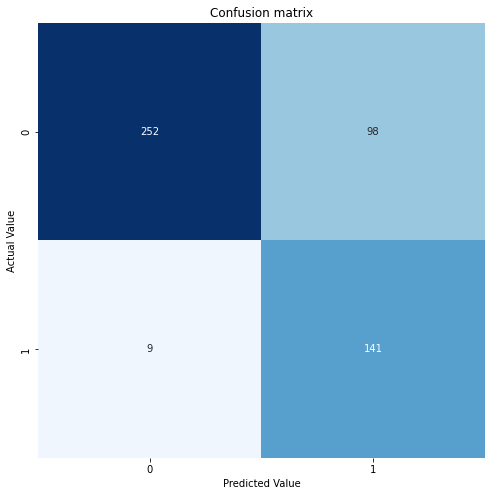

In [43]:
from sklearn.metrics import confusion_matrix,roc_auc_score, classification_report
import seaborn as sns
c_matrix =confusion_matrix(y_test,y_pred)
print(c_matrix)
clr = classification_report(y_test,y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(c_matrix,annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.title("Confusion matrix")
plt.show()

In [44]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.72      0.82       350
           1       0.59      0.94      0.72       150

    accuracy                           0.79       500
   macro avg       0.78      0.83      0.77       500
weighted avg       0.85      0.79      0.79       500

